# Rainbow Trout Meat Quality Classification using Genomic Data 

## Imports

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import json

from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

SEED = 32
%autosave 30

Autosaving every 30 seconds


In [70]:
import gc

import warnings
warnings.filterwarnings("ignore")

## Meta Data Creation

In [71]:
# %%time
# metadf_init = pd.read_excel("./data/GeneExpressionData/Meta_data.xlsx", usecols=['genetic line','Orso_Id'])
# print(f"Initial Dataframe Size:{metadf_init.shape}")

# #Dropping rows with NaN values.
# metadf_init.dropna(inplace=True)
# print(f"Dataframe Size post cleaning:{metadf_init.shape}")
# metadf_init.head()

In [72]:
# def processRows(row):
#     geneLine, fishId = row['genetic line'].split('-')[-1], row['Orso_Id'].split('_')[-1]
#     # print(geneLine, fishId)
#     return pd.Series(data = [f"F{fishId}", 'high' if geneLine=='H' else 'low'], index=['FishID', 'GeneLine'])

# metadf_init.apply(processRows, axis=1).to_csv("./metaFishData.csv", index=False)

## Meta Data

In [73]:
metadf = pd.read_csv("./metaFishData.csv")
metadf.head()

,FishID,GeneLine
0,F75,high
1,F66,low
2,F76,high
3,F72,low
4,F78,high


In [74]:
metadf['GeneLine'].value_counts(normalize=True)

GeneLine
high    0.504298
low     0.495702
Name: proportion, dtype: float64

## Metaphlan Profile

In [75]:
%%time
mp_df = pd.read_csv("./data/GeneExpressionData/merged_metaphlan_profile.tsv", sep='\t', header=0).reset_index()
print(f"Metaphlan Profile Data Shape: {mp_df.shape}")

#Generating consistent Fish Identification Marking
fishIdentifierFnx = lambda row: f'F{row.split("_")[3]}'
mp_df.iloc[0, 1:] = mp_df.iloc[0, 1:].apply(fishIdentifierFnx)

#Setting Column Names to the fish identification markings
mp_df.columns = mp_df.iloc[0]
mp_df.drop(mp_df.index[0], inplace=True)
mp_df.head()

Metaphlan Profile Data Shape: (1567, 352)
CPU times: user 245 ms, sys: 11.9 ms, total: 257 ms
Wall time: 283 ms


,clade_name,F100,F101,F102,F103,F104,F105,F106,F107,F108,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F9
1,k__Bacteria,100.0,99.97197,100.0,100.0,100.0,99.99576,99.98729,100.0,100.0,...,100.0,100.0,99.99293,100.0,100.0,100.0,100.0,100.0,100.0,99.99385
2,k__Bacteria|p__Proteobacteria,96.23163,1.28278,2.46132,4.19295,0.61851,0.09897,7.26275,0.26161,4.19682,...,12.66281,0.96307,18.82358,0.32609,0.02745,0.0,44.74296,0.15063,0.0,0.66998
3,k__Bacteria|p__Fusobacteria,1.90922,0.02158,96.92149,0.24615,91.75045,0.10025,0.05683,43.08036,95.27552,...,82.35353,98.30658,79.81764,36.31168,99.72513,1.57367,17.83804,98.75345,97.18932,79.67032
4,k__Bacteria|p__Firmicutes,1.85915,97.78226,0.4784,87.89138,6.77893,80.14233,92.20322,56.095,0.52766,...,4.60755,0.63897,1.25554,61.489,0.1855,98.42633,34.07137,1.09592,2.81068,18.22957
5,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,95.58687,0.0,1.11736,0.05299,0.0497,0.0,0.00083,0.0,2.79746,...,11.30934,0.37437,18.81727,0.06843,0.0,0.0,44.66672,0.15063,0.0,0.56759


## Clade Family

In [76]:
from treelib import Node, Tree

In [77]:
clade = mp_df.iloc[:, 0]

cladeFnxLambda = lambda row: len(row.split('|'))
clade.apply(cladeFnxLambda).value_counts()

clade_name
8    560
7    539
6    260
5    101
4     54
3     37
2     11
1      4
Name: count, dtype: int64

In [78]:
# cladeFnxLambda = lambda row: row.split('|')
# clade.apply(cladeFnxLambda).value_counts()

In [79]:
%%time
tree = Tree()
tree.create_node('Main', 'main')
def cladeFnxTree(row):
    row = row.split('|')
    if len(row)==1:
        tree.create_node(row[0], row[0], parent='main')
    else:
        tree.create_node(row[-1], row[-1], parent=row[-2])
             
_ = clade.apply(cladeFnxTree)

print("Depth of tree:", tree.depth())
# tree.show()      

Depth of tree: 8
CPU times: user 84 ms, sys: 3.12 ms, total: 87.1 ms
Wall time: 85.8 ms


In [80]:
treeFamily = json.loads(tree.to_json(with_data=False))

In [81]:
familyMap = {f'level{r}':[] for r in range(0,8)}

# def cladeFnx(row):
#     row = row.split('|')
#     i = 0
#     for rw in row:
#         familyMap[f'level{i}'].append(rw)
#         i+=1
#     while i<8:
#         familyMap[f'level{i}'].append(None)
#         i+=1

def cladeFnx(row):
    row_ = row.split('|')
    familyMap[f'level{len(row_)-1}'].append(row)
    
    

_ = clade.apply(cladeFnx)

In [82]:
for i in familyMap:
    familyMap[i] = list(set(familyMap[i]))

familyMapRev = {}
for i in familyMap:
    for j in familyMap[i]:
        familyMapRev[j] = i

## Initial Exploration

In [83]:
mp_fin = mp_df.set_index('clade_name').T
mp_fin = mp_fin.apply(pd.to_numeric, downcast='float')

mp_fin = pd.merge(left=mp_fin, right=metadf, left_index=True, right_on='FishID', how='inner').drop('FishID', axis=1)
mp_fin.dropna(inplace=True)
print(mp_fin.shape)

(349, 1567)


In [84]:
# mp_fin.to_csv("./data/mergedMetaPhlanData.csv", index=False)

In [85]:
mp_fin.head()

,k__Bacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Fusobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Clostridia,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria,k__Bacteria|p__Firmicutes|c__Tissierellia,...,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__SGB16671,k__Eukaryota|p__Basidiomycota,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta|t__EUK76775,GeneLine
181,100.00000,96.231628,1.909220,1.859150,95.586868,1.909220,1.114860,0.742340,0.64476,0.00196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
209,99.97197,1.282780,0.021580,97.782257,0.000000,0.021580,68.893913,27.902140,1.28278,0.60573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
246,100.00000,2.461320,96.921494,0.478400,1.117360,96.921494,0.320890,0.157520,1.34395,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
78,100.00000,4.192950,0.246150,87.891380,0.052990,0.246150,63.512451,24.072491,3.15654,0.19579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
265,100.00000,0.618510,91.750450,6.778930,0.049700,91.750450,5.072790,1.677510,0.56792,0.02729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high


### Outlier Analysis

In [86]:
mp_fin.iloc[:, :].shape

(349, 1567)

In [87]:
# Number of outliers in each column
def outliersFnx(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return len(data[s>m])

In [88]:
fnx = lambda row: type(row.values)
fnx = lambda row: outliersFnx(row.values)
outlierCount = mp_fin.iloc[:, :-1].apply(fnx, axis=0).values

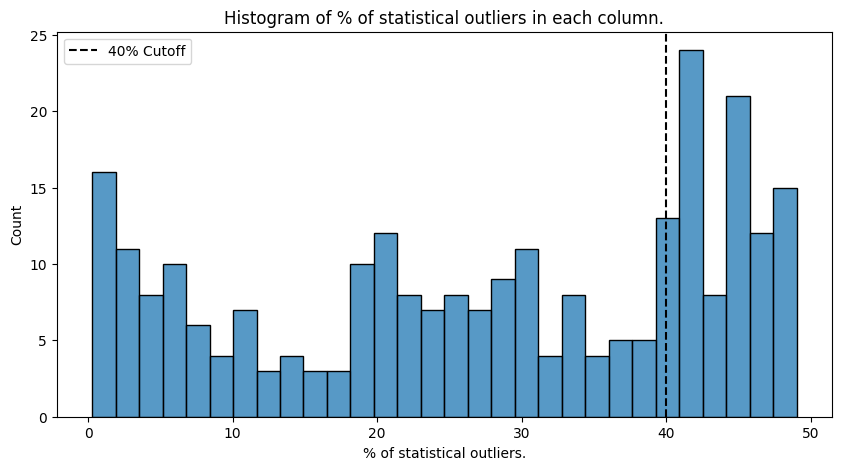

In [89]:
OUTLIER_CUTOFF = 40
plt.figure(figsize=(10,5), dpi = 100)
sns.histplot(data=outlierCount[outlierCount!=0]*100/(mp_df.shape[1]-1), bins=30)
plt.axvline(x=OUTLIER_CUTOFF, color='black', linestyle='--', label='40% Cutoff')
plt.legend()
plt.title("Histogram of % of statistical outliers in each column.")
plt.xlabel("% of statistical outliers.")
plt.show()

The dashed vertical lines represents the cutoff mark, beyond which there are features with more than the cutoff statistical outlier values.

In [90]:
var_ = outlierCount*100/(mp_df.shape[1]-1)
len(var_[var_>40])

print(f"{len(var_[var_>40])} out of {len(var_)} features have more than {OUTLIER_CUTOFF}% datapoints as statistical outliers.")

89 out of 1566 features have more than 40% datapoints as statistical outliers.


In [105]:
hmap = {'feature':[], 'outlierCount':[], 'outlierCount%':[], 'level':[]}
for i,j  in zip(mp_fin.columns, outlierCount):
    hmap['feature'].append(i)
    hmap['outlierCount'].append(j)
    hmap['outlierCount%'].append(j*100/mp_df.shape[1])
    hmap['level'].append(len(i.split('|')))
    
outlierDf = pd.DataFrame(hmap)

In [109]:
len(hmap['feature'])
len(outlierCount)

1566

In [104]:
len(mp_fin.columns)

1567

In [101]:
outlierDf.shape

(1566, 4)

In [92]:
outlierDf[outlierDf['outlierCount%']>OUTLIER_CUTOFF].head()

,feature,outlierCount,outlierCount%,level
2,k__Bacteria|p__Fusobacteria,148,42.045455,2
5,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,148,42.045455,3
10,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,148,42.045455,4
11,k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o...,148,42.045455,4
14,k__Bacteria|p__Proteobacteria|c__Betaproteobac...,150,42.613636,4


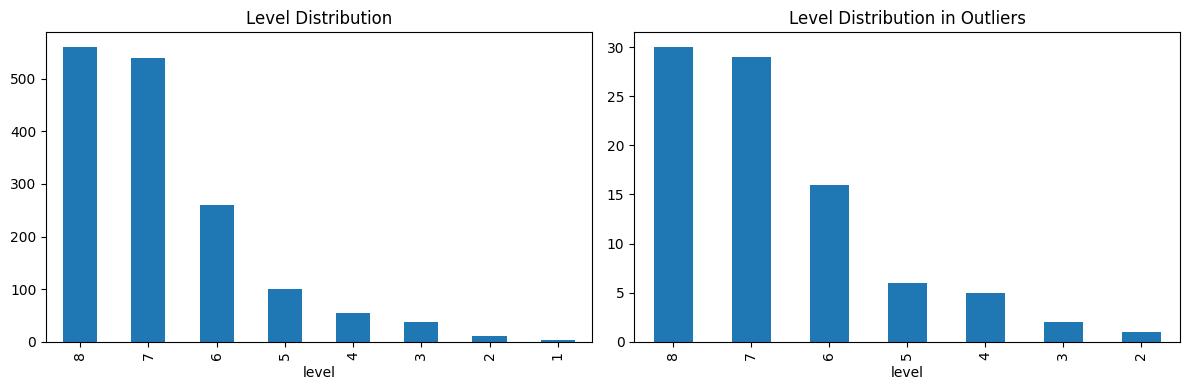

In [93]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
outlierDf['level'].value_counts().plot(kind='bar', ax=ax[0])
outlierDf[outlierDf['outlierCount%']>OUTLIER_CUTOFF]['level'].value_counts().plot(kind='bar', ax=ax[1])

ax[0].set_title('Level Distribution')
ax[1].set_title('Level Distribution in Outliers')
plt.tight_layout()
plt.show()

In [94]:
# Variance
mp_fin.groupby('GeneLine').var()

,k__Bacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Fusobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Clostridia,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria,k__Bacteria|p__Firmicutes|c__Tissierellia,...,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Corynebacteriales|f__Nocardiaceae|g__Nocardia|s__Nocardia_sp_MH4|t__SGB110840,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__SGB16671,k__Eukaryota|p__Basidiomycota,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta|t__EUK76775
GeneLine,,,,,,,,,,,,,,,,,,,,,
high,56.823902,487.603271,1537.609863,1628.704590,417.994049,1537.609863,944.691589,132.519058,96.790024,0.029175,...,0.0,0.000000e+00,0.000000e+00,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07,2.840051e-07
low,58.872559,492.462982,1539.468018,1597.708618,360.880707,1539.468018,949.266418,178.377350,139.633316,0.023393,...,0.0,1.406705e-08,1.406705e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [95]:
LEVEL = 'level7'
temp_ = mp_fin.loc[:, familyMap[LEVEL]+['GeneLine']].groupby('GeneLine').mean().T
temp_ = temp_[temp_['high']<30]
temp_.head()

GeneLine,high,low
k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Lachnospiraceae|g__Lachnoclostridium|s__Lachnoclostridium_phocaeense|t__SGB4622,0.002094,0.002665
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Limosilactobacillus|s__Limosilactobacillus_panis|t__SGB7094,0.000004,0.000007
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus|s__Vagococcus_fluvialis|t__SGB7918,0.284742,0.262435
k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Propionibacteriales|f__Propionibacteriaceae|g__Arachnia|s__Arachnia_propionica|t__SGB15897,0.000000,0.000206
k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_aureus|t__SGB7852,0.000000,0.000263


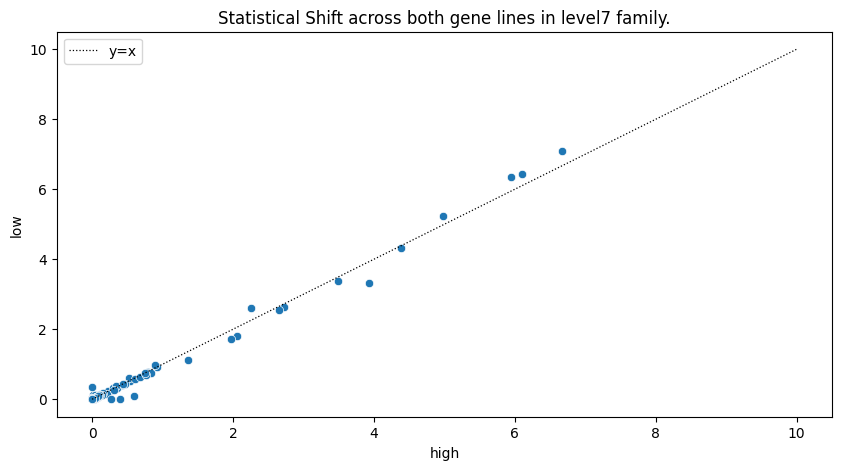

In [96]:
t_ = 10

plt.figure(figsize=(10, 5), dpi = 100)
sns.scatterplot(x=temp_['high'], y=temp_['low'])
plt.plot([0,t_], [0, t_], ls=':', color='black', linewidth = .9, label='y=x')
plt.title(f"Statistical Shift across both gene lines in {LEVEL} family.")
plt.legend()
plt.show()

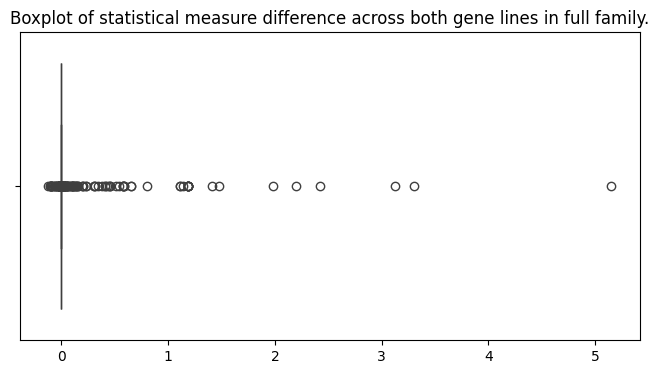

In [97]:
LEVEL = 'full'
temp2_ = mp_fin.groupby('GeneLine').median().T
temp2Diff_ = (temp2_['high']-temp2_['low'])

plt.figure(figsize=(8, 4), dpi = 100)
sns.boxplot(data=temp2Diff_, showfliers=True, orient = 'h')

plt.title(f"Boxplot of statistical measure difference across both gene lines in {LEVEL} family.")
plt.show()

We see that several features are present in the outlier region

In [98]:
# temp2_ = mp_fin.groupby('GeneLine').mean().T
# temp2_ = mp_fin.groupby('GeneLine').median().T
# temp2_ = mp_fin.groupby('GeneLine').var().T
# temp2Diff_ = (temp2_['high']-temp2_['low'])

# outlierDf = pd.merge(left=outlierDf, right = temp2Diff_.rename("statVarDiff"), left_on='feature', right_index=True)

### Mutual Importance

In [158]:
from sklearn.feature_selection import mutual_info_classif

In [175]:
%%time
# Mutual Information
mi = mutual_info_classif(mp_fin.iloc[:, :-1], mp_fin.iloc[:, -1].replace({'high':1, 'low':0}))

CPU times: user 1.14 s, sys: 16.7 ms, total: 1.15 s
Wall time: 1.15 s


In [176]:
outlierDf = outlierDf.assign(mi=mi)

array([0., 0., 0., ..., 0., 0., 0.])

In [208]:
# outlierDf[outlierDf['mi']!=0].sort_values('mi', ascending=False)

In [190]:
# outlierDf.to_csv("./metaFishOutlierData.csv", index=False)

# Machine Learning

Data Creation

In [119]:
outlierDf = pd.read_csv("./metaFishOutlierData.csv")
mp_df = pd.read_csv("./data/mergedMetaPhlanData.csv")

In [120]:
mp_df.head()

,k__Bacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Fusobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria,k__Bacteria|p__Fusobacteria|c__Fusobacteriia,k__Bacteria|p__Firmicutes|c__Bacilli,k__Bacteria|p__Firmicutes|c__Clostridia,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria,k__Bacteria|p__Firmicutes|c__Tissierellia,...,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila,k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__SGB16671,k__Eukaryota|p__Basidiomycota,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta,k__Eukaryota|p__Basidiomycota|c__Malasseziomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_restricta|t__EUK76775,GeneLine
0,100.00000,96.23163,1.90922,1.85915,95.58687,1.90922,1.11486,0.74234,0.64476,0.00196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
1,99.97197,1.28278,0.02158,97.78226,0.00000,0.02158,68.89391,27.90214,1.28278,0.60573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
2,100.00000,2.46132,96.92149,0.47840,1.11736,96.92149,0.32089,0.15752,1.34395,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
3,100.00000,4.19295,0.24615,87.89138,0.05299,0.24615,63.51245,24.07249,3.15654,0.19579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high
4,100.00000,0.61851,91.75045,6.77893,0.04970,91.75045,5.07279,1.67751,0.56792,0.02729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,high


In [121]:
def genDataFnx(columns='full', scale=None, test_size=0.3, stratify=False, SEED=SEED, data=mp_df):
    '''
    args
    data: input dataframe. default mp_df
    columns: columns to consider. default 'full'. inputs list.
    scale: scaling strategy. default None. inputs 'standard', 'minmax'.
    test_size: data split test size. defaults 0.3. inputs float, None (no train test split).
    stratify: stratify strategy. defaults False. On labels if True.
    SEED: random state SEED
    '''
    dataModel = mp_df.copy()
    dataModel.replace({'GeneLine':{'high':1, 'low':0}}, inplace=True)

    if columns == 'full':
        xdata, ydata = dataModel.iloc[:,:-1], dataModel.iloc[:,-1]
    else:
        xdata, ydata = dataModel.loc[:,columns], dataModel.iloc[:,-1]
    sca = None
    if scale=='standard':
        sca = StandardScaler()
        xdata = sca.fit_transform(xdata)
    elif scale=='minmax':
        sca = MinMaxScaler()
        xdata = sca.fit_transform(xdata)

    if test_size==None:
        return np.array(xdata), np.array(ydata)

    if stratify==False:
        xstrain, xstest, ytrain, ytest = train_test_split(xdata, ydata, test_size=test_size, random_state=SEED)
    else:
        xstrain, xstest, ytrain, ytest = train_test_split(xdata, ydata, test_size=test_size, stratify=ydata, random_state=SEED)
    
    xstrain, xstest = np.array(xstrain), np.array(xstest)
    del dataModel, xdata, ydata
    gc.collect()
    return xstrain, xstest, ytrain, ytest, sca

xtrain, xtest, ytrain, ytest, _ = genDataFnx()

In [122]:
def resultAnalysisFnx(ytrue,ypred,target_names=None,plot=True):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    
    plt.figure(figsize=(4, 3))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

In [123]:
TARGETNAMES = ['low', 'high']

## Naive Bayes - Gaussian

In [124]:
from sklearn.naive_bayes import GaussianNB

In [125]:
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale=None)

In [126]:
%%time
gnb = GaussianNB()
gnb.fit(xtrain, ytrain)

ypred = gnb.predict(xtest)

CPU times: user 11.2 ms, sys: 4.95 ms, total: 16.1 ms
Wall time: 13.2 ms


In [127]:
ytest.value_counts()

GeneLine
0    57
1    48
Name: count, dtype: int64

              precision    recall  f1-score   support

         low       0.60      0.21      0.31        57
        high       0.47      0.83      0.60        48

    accuracy                           0.50       105
   macro avg       0.54      0.52      0.46       105
weighted avg       0.54      0.50      0.44       105



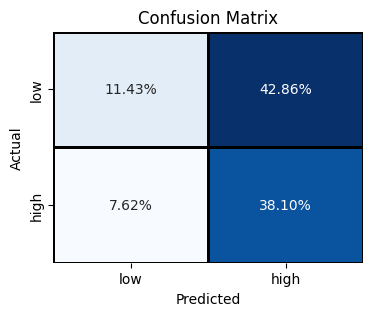

In [128]:
_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### KFold CV

In [129]:
xdata, ydata = genDataFnx(test_size=None)
gnbK = GaussianNB()

In [193]:
CV = 10
scores = cross_val_score(gnbK, xdata, ydata, cv=5, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.63% accuracy with a standard deviation of 0.06 for 10 folds.


### MI Fea Imp Columns

In [166]:
colExp = outlierDf[outlierDf['mi']!=0]['feature'].values.tolist()
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)

In [167]:
%%time
gnb = GaussianNB()
gnb.fit(xtrainE, ytrainE)

ypredE = gnb.predict(xtestE)

CPU times: user 6.29 ms, sys: 3.85 ms, total: 10.1 ms
Wall time: 7.63 ms


              precision    recall  f1-score   support

         low       0.63      0.21      0.32        57
        high       0.48      0.85      0.61        48

    accuracy                           0.50       105
   macro avg       0.55      0.53      0.46       105
weighted avg       0.56      0.50      0.45       105



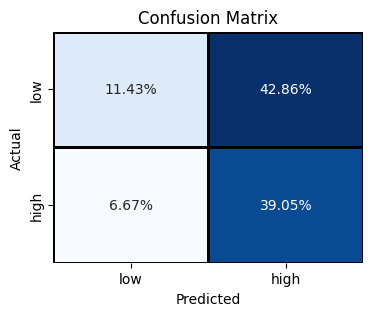

In [168]:
_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### NB - Level Wise

In [219]:
for i in range(1, 9):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)
    gnb = GaussianNB()
    gnb.fit(xtrainE, ytrainE)
    
    ypredE = gnb.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    acc.append(tt['accuracy'])
    print(f"Number of Columns at level{i}: {len(colExp)} with acc of {tt['accuracy']*100:.2f}%")

Number of Columns at level1: 4 with acc of 41.90%
Number of Columns at level2: 11 with acc of 42.86%
Number of Columns at level3: 37 with acc of 42.86%
Number of Columns at level4: 54 with acc of 43.81%
Number of Columns at level5: 101 with acc of 51.43%
Number of Columns at level6: 260 with acc of 51.43%
Number of Columns at level7: 539 with acc of 51.43%
Number of Columns at level8: 560 with acc of 51.43%


## Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')

In [132]:
%%time
logres = LogisticRegression(random_state=SEED)

logres.fit(xtrain, ytrain)

ypred = logres.predict(xtest)

CPU times: user 397 ms, sys: 10.8 ms, total: 408 ms
Wall time: 67 ms


              precision    recall  f1-score   support

         low       0.65      0.42      0.51        57
        high       0.51      0.73      0.60        48

    accuracy                           0.56       105
   macro avg       0.58      0.58      0.56       105
weighted avg       0.59      0.56      0.55       105



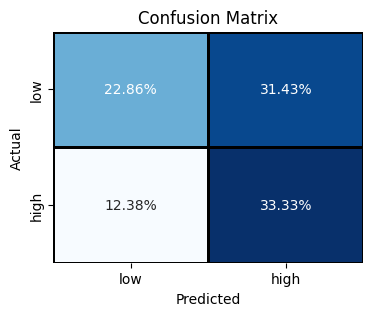

In [133]:
_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### Feature Importance

In [134]:
feature_importance = logres.coef_[0]

In [144]:
odf_temp = outlierDf.assign(logresFeaImp = feature_importance)

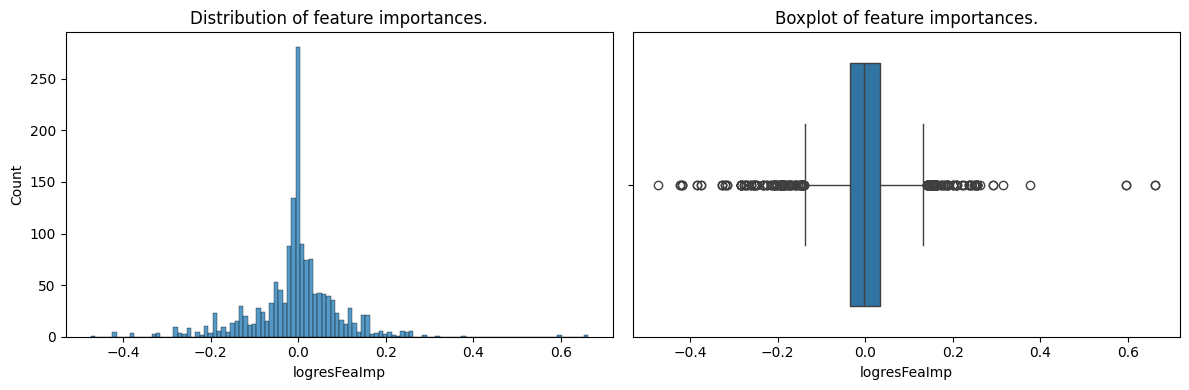

In [176]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
sns.histplot(data=odf_temp['logresFeaImp'], binwidth=0.01, ax=ax[0])
sns.boxplot(data=odf_temp['logresFeaImp'], orient='h', ax=ax[1])
ax[0].set_title('Distribution of feature importances.')
ax[1].set_title('Boxplot of feature importances.')
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

         low       0.58      0.26      0.36        57
        high       0.47      0.77      0.58        48

    accuracy                           0.50       105
   macro avg       0.52      0.52      0.47       105
weighted avg       0.53      0.50      0.46       105



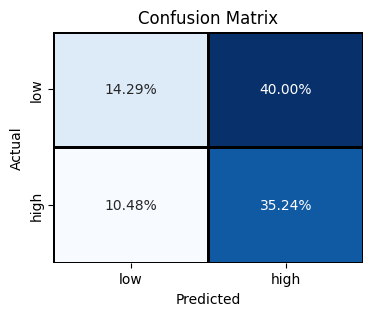

CPU times: user 337 ms, sys: 463 ms, total: 800 ms
Wall time: 205 ms


In [181]:
%%time
colExp = odf_temp[(odf_temp['logresFeaImp']<-0.1)|(odf_temp['logresFeaImp']>0.1)]['feature'].values.tolist()
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)

logres = LogisticRegression(random_state=SEED)
logres.fit(xtrainE, ytrainE)

ypredE = logres.predict(xtestE)

_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### KFold CV

In [195]:
xdata, ydata = genDataFnx(scale='standard', test_size=None)

logresK = LogisticRegression(random_state=SEED)

CV = 10
scores = cross_val_score(logresK, xdata, ydata, cv=5, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.56% accuracy with a standard deviation of 0.08 for 10 folds.


### MI Fea Imp Columns

              precision    recall  f1-score   support

         low       0.49      0.30      0.37        57
        high       0.43      0.62      0.51        48

    accuracy                           0.45       105
   macro avg       0.46      0.46      0.44       105
weighted avg       0.46      0.45      0.43       105



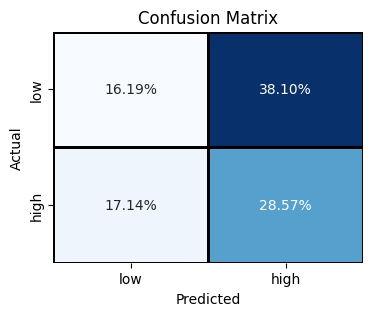

CPU times: user 409 ms, sys: 199 ms, total: 607 ms
Wall time: 174 ms


In [170]:
%%time
colExp = outlierDf[outlierDf['mi']!=0]['feature'].values.tolist()
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)

logres = LogisticRegression(random_state=SEED)
logres.fit(xtrainE, ytrainE)

ypredE = logres.predict(xtestE)

_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### LogRes - Level Wise

In [221]:
for i in range(1, 9):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale='standard')
    
    logres = LogisticRegression(random_state=SEED)
    logres.fit(xtrainE, ytrainE)
    
    ypredE = logres.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    print(f"Number of Columns at level{i}: {len(colExp)} with acc of {tt['accuracy']*100:.2f}%")

Number of Columns at level1: 4 with acc of 41.90%
Number of Columns at level2: 11 with acc of 42.86%
Number of Columns at level3: 37 with acc of 43.81%
Number of Columns at level4: 54 with acc of 47.62%
Number of Columns at level5: 101 with acc of 52.38%
Number of Columns at level6: 260 with acc of 53.33%
Number of Columns at level7: 539 with acc of 55.24%
Number of Columns at level8: 560 with acc of 56.19%


## Decision Tree

In [183]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

         low       0.63      0.60      0.61        57
        high       0.55      0.58      0.57        48

    accuracy                           0.59       105
   macro avg       0.59      0.59      0.59       105
weighted avg       0.59      0.59      0.59       105



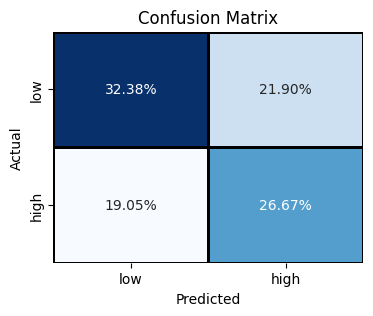

CPU times: user 195 ms, sys: 7.86 ms, total: 203 ms
Wall time: 170 ms


In [185]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale=None)
dt = DecisionTreeClassifier()

dt.fit(xtrain, ytrain)
ypred = dt.predict(xtest)

_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### KFold CV

In [197]:
xdata, ydata = genDataFnx(scale=None, test_size=None)

dtK = DecisionTreeClassifier()

CV = 10
scores = cross_val_score(dtK, xdata, ydata, cv=5, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.53% accuracy with a standard deviation of 0.07 for 10 folds.


In [198]:
scores

array([0.57534247, 0.62162162, 0.47887324, 0.57534247, 0.41935484])

## DT - Level Wise

In [ ]:
for i in range(1, 9):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale='standard')
    
    logres = LogisticRegression(random_state=SEED)
    logres.fit(xtrainE, ytrainE)
    
    ypredE = logres.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    print(f"Number of Columns at level{i}: {len(colExp)} with acc of {tt['accuracy']*100:.2f}%")

## Random Forest

              precision    recall  f1-score   support

         low       0.62      0.46      0.53        57
        high       0.51      0.67      0.58        48

    accuracy                           0.55       105
   macro avg       0.56      0.56      0.55       105
weighted avg       0.57      0.55      0.55       105



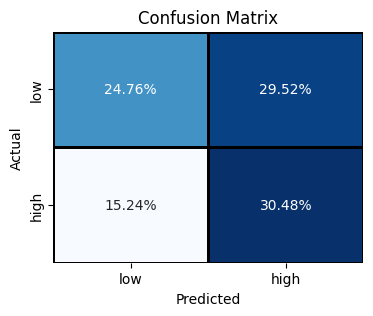

CPU times: user 262 ms, sys: 8.98 ms, total: 271 ms
Wall time: 243 ms


In [199]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale=None)
rf = RandomForestClassifier()

rf.fit(xtrain, ytrain)
ypred = rf.predict(xtest)

_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)